In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import corrcoef
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [2]:
import matplotlib
font = {'sans-serif' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# load data

In [3]:
species = !ls ../../data/preprocessed/gex_counts_by_sample/

In [4]:
species

['human', 'macaque', 'marmoset', 'mouse']

In [5]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

In [6]:
def common_index(a, b):
    '''
    finds the common indicies between two pandas dataframes
    
    args:
        a: a pandas dataframe  with some indecies in common w/ b
        b: a pandas dataframe with some indecies in common w/ a
    returns:
        a_prime : the dataframe a indexed by common elements with a
        b_prime : the dataframe b indexed by common elements with b
    '''
    a_prime = a.loc[a.index.isin(b.index)]
    b_prime = b.loc[a_prime.index]
    return a_prime, b_prime

In [7]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

# Calculate GLS

In [8]:
from scipy.stats import pearsonr

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
path = '../../data/processed/atac_for_gls/{}_origin_peaks/log2cpm/'
tail = '{}_clusters_orthologous_counts.txt'

In [12]:
species

['human', 'macaque', 'marmoset', 'mouse']

In [11]:
for orgin in species:
    path_use = path.format(orgin) + tail
    print(f'calculating gls for {orgin} peaks')
    clust_measures = {specie : pd.read_csv(path_use.format(specie),
                                        sep = '\t').set_index(orgin) for specie in species}
    out_dir = '../../data/outputs/atac_gls_results/{}_origin/'.format(orgin)
    !mkdir -p $out_dir
    !ls $out_dir
    !mkdir -p {out_dir}/log2cpm
    for pair in pairs_use:
        spec1, spec2 = pair
        df1 = clust_measures[spec1]
        df2 = clust_measures[spec2]
        df1_ids = df1.loc[((df1 > 2).sum(axis=1) > 1) & ((df2 > 1).sum(axis=1) > 1)].index.values
        df2_ids = df2.loc[((df2 > 2).sum(axis=1) > 1) & ((df1 > 1).sum(axis=1) > 1)].index.values
        use_ids = np.unique(np.concatenate([df1_ids, df2_ids]))
        df1 = df1.loc[use_ids]
        df2 = df2.loc[use_ids]
        df1, df2 = common_index(df1, df2)
        print(df1.shape, df2.shape)

        # n_neighbors.fit(df1.values)
        cov_use = (cov(df1.values.T) + cov(df2.values.T))/2
        n_gene = df1.shape[0]
        r_square = [None] * n_gene
        param = [None] * n_gene
        p_vals = [None] * n_gene
        t_vals = [None] * n_gene
        corr = [None] * n_gene
        corr_p = [None] * n_gene
        pear_corr =[None] * n_gene
        pear_p = [None] * n_gene
        residuals = [None] * n_gene
        for idx in range(n_gene):
            model = GLS(df1.iloc[idx].values, df2.iloc[idx].values, sigma=cov_use)
            res = model.fit()
            r_square[idx] = res.rsquared
            p_vals[idx] = res.pvalues[0]
            param[idx] = res.params[0]
            t_vals[idx] = res.t_test([1]).tvalue[0][0]
            residuals[idx] = np.nanmean(np.abs(res.resid / df2.iloc[idx].values))
            # compare to correlation
            corr_, corr_p_ = spearmanr(df1.iloc[idx].values, df2.iloc[idx].values)
            corr[idx] = corr_
            corr_p[idx] = corr_p_ 
            pear_c, pear_p_ = pearsonr(df1.iloc[idx].values, df2.iloc[idx].values)
            pear_corr[idx] = pear_c
            pear_p[idx] = pear_p_
        p_vals = np.nan_to_num(np.array(p_vals), nan=1)
        sig, fdr = fdrcorrection(p_vals, alpha=.05, method='n')
        sig_corr, fdr_corr = fdrcorrection(corr_p, alpha=.05, method='n')
        sig_pearson, fdr_pear = fdrcorrection(pear_p, alpha=.05, method='n')

        print(np.sum(fdr < .05), spec1, spec2)
        print(sig_corr.sum())
        df_res = pd.DataFrame(np.array([r_square, param, p_vals, t_vals, fdr, corr, fdr_corr, pear_corr, fdr_pear, residuals]).T,
                            index=df1.index,
                            columns=['r_square', 'coeff', 'p_val', 't_val', 'fdr', 'corr', 'fdr_corr', 'pear_corr', 'fdr_pear', 'mean_scaled_residual'])
        print('/gls_{}_{}.tsv'.format(spec1, spec2), df_res.shape)
        df_res.to_csv(out_dir + 'log2cpm/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')

calculating gls for human peaks
log2cpm
(170389, 21) (170389, 21)
76155 human macaque
77447
/gls_human_macaque.tsv (170389, 10)
(171113, 21) (171113, 21)
62355 human marmoset
65247
/gls_human_marmoset.tsv (171113, 10)
(166902, 21) (166902, 21)
25620 human mouse
29349
/gls_human_mouse.tsv (166902, 10)
(144418, 21) (144418, 21)
60381 macaque marmoset
58796
/gls_macaque_marmoset.tsv (144418, 10)
(143451, 21) (143451, 21)
26107 macaque mouse
27660
/gls_macaque_mouse.tsv (143451, 10)
(142311, 21) (142311, 21)
28147 marmoset mouse
27444
/gls_marmoset_mouse.tsv (142311, 10)
calculating gls for macaque peaks
(160543, 21) (160543, 21)
76019 human macaque
74417
/gls_human_macaque.tsv (160543, 10)
(151618, 21) (151618, 21)
59536 human marmoset
59531
/gls_human_marmoset.tsv (151618, 10)
(149947, 21) (149947, 21)
46543 human marmoset
47032
/gls_human_marmoset.tsv (134843, 10)
(168084, 21) (168084, 21)
23176 human mouse
25634
/gls_human_mouse.tsv (168084, 10)
(118765, 21) (118765, 21)
46321 macaque 

48265 102980
37593 90203
16839 47148
40126 79580
17791 42569
18793 43786


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal


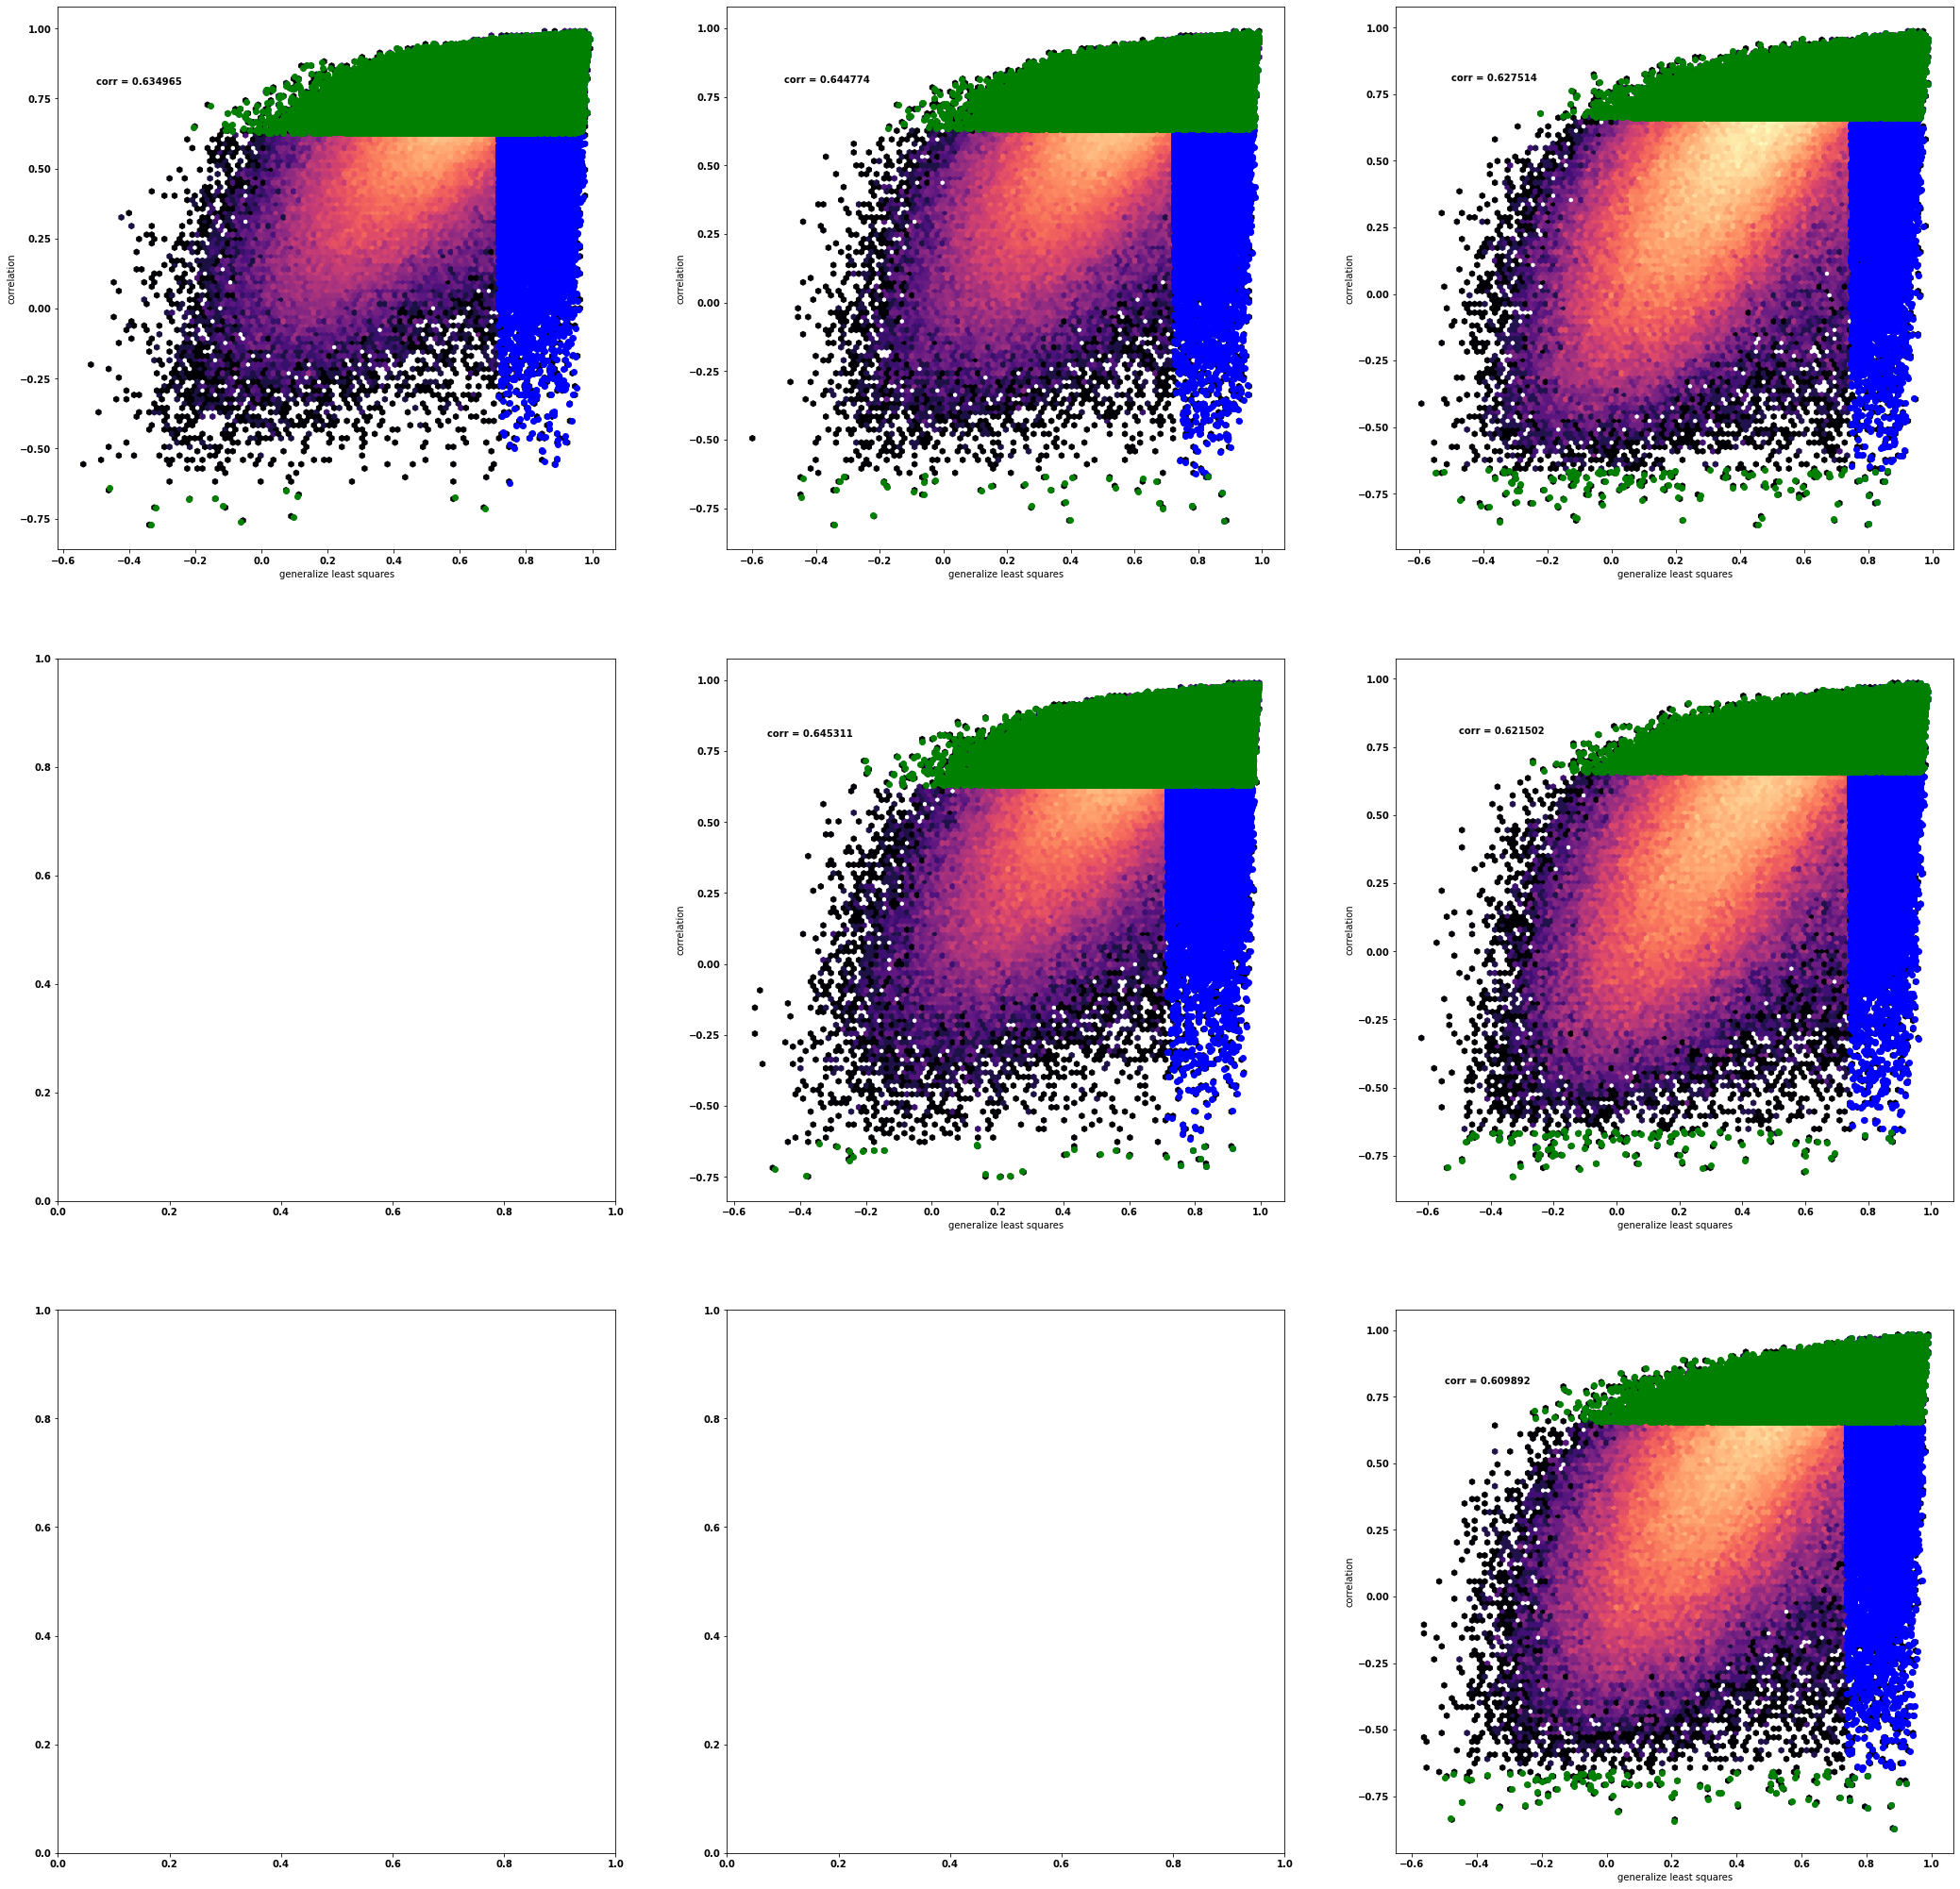

In [14]:
gene_gls = []
gene_corr = []
a_cons = []
p_cons = []

a_bg = []
p_bg = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/experimental/human_origin/log2cpm/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_pear'] < .05
    gene_gls.append(stats.loc[sig_gls]['human'].values)
    gene_corr.append(stats.loc[sig_corr]['human'].values)
    a_cons.append(stats.loc[stats['fdr'] < .05].human.values)
    a_bg.append(stats.human.values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05].human.values)
        p_bg.append(stats.human.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [15]:
def list_intersection(to_intersect):
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [16]:
len(list_intersection(a_cons))

15914

In [17]:
len(list_intersection(p_cons))

38128

In [ ]:
high_cons = np.unique(np.concatenate(gene_gls))

In [ ]:
len(high_cons)

In [ ]:
len(np.setdiff1d(list_intersection(p_cons), list_intersection(a_cons)))

In [ ]:
pair_cons= np.setdiff1d(list_intersection(p_cons), high_cons)

In [ ]:
len(pair_cons)

# examine models

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# relative

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = stats.t_val
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = (stats['fdr_corr'] < .05) &(stats['coeff'] > 0)
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [15]:
lhx_check = [i.loc['LHX6'] for i in clust_measures.values()]

KeyError: 'LHX6'

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('lhx_6 by species')

In [ ]:
lhx_check = [i.loc['SLC17A7'] for i in clust_measures.values()]

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 by species')

In [ ]:
corr_mat = np.square(np.corrcoef(check.values.T))

In [ ]:
np.fill_diagonal(corr_mat, .74)

In [ ]:
np.corrcoef(check.values.T)

In [ ]:
im = plt.imshow(corr_mat)
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('% variance explained',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
im = plt.imshow(np.corrcoef(check.values.T))
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
stats_z.loc[stats_z.t_val> 15]

In [ ]:
stats.loc[(stats_z.t_val> 10) & (stats.t_val < 10)]

In [ ]:
stats.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats_z.fdr < .05/6].t_val.min()

In [ ]:
stats.loc[stats.fdr < .05/6].t_val.min()

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['pear_corr']
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
primate = list_intersection(gene_gls[:3])

In [ ]:
primate_corr = list_intersection(gene_corr[:3])

In [ ]:
len(primate),len(primate_corr)

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr))

In [ ]:
x = [i.loc[list_intersection(gene_gls)].mean(axis=1) for i in clust_measures.values()]

In [ ]:
y = [i.loc[~i.index.isin(list_intersection(gene_gls))].mean(axis=1) for i in clust_measures.values()]

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr)) 

In [ ]:
list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)])

In [ ]:
len(list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)]))

In [ ]:
len(list_intersection(gene_gls))/10790 *  len(list_intersection(gene_corr))/10790

In [ ]:
plt.hexbin(stats['t_val'], stats['coeff'], bins='log', cmap='magma')